In [124]:
using PyPlot, SparseArrays, Polynomials, DelaunayTriangulation
import Delaunator as D

In [87]:
"""
    edges, boundary_indices, emap = all_edges(t)

Handout from mesh_utilities
Find all unique edges in the triangulation `t` (ne x 2 array)
Second output is indices to the boundary edges.
Third output emap (nt x 3 array) is a mapping from local triangle edges
to the global edge list, i.e., emap[it,k] is the global edge number
for local edge k (1,2,3) in triangle it.
"""
function all_edges(t)
    etag = vcat(t[:,[1,2]], t[:,[2,3]], t[:,[3,1]])
    etag = hcat(sort(etag, dims=2), 1:3*size(t,1))
    etag = sortslices(etag, dims=1)
    dup = all(etag[2:end,1:2] - etag[1:end-1,1:2] .== 0, dims=2)[:]
    keep = .![false;dup]
    edges = etag[keep,1:2]
    emap = cumsum(keep)
    invpermute!(emap, etag[:,3])
    emap = reshape(emap,:,3)
    dup = [dup;false]
    dup = dup[keep]
    bndix = findall(.!dup)
    return edges, bndix, emap
end

"""
    t = delaunay(p)

Delaunay triangulation `t` of N x 2 node array `p`.
"""
#delaunay(p) = collect(reinterpret(reshape, Int32, 
        #D.triangulate(D.PointsFromMatrix(p')).triangles)')
delaunay(p) = delaunay_lib(p)
function delaunay_lib(p)
    tt = triangulate(p').triangles
    t = zeros(Int, length(tt), 3);

    for (i, (a, b, c)) in enumerate(tt)   
        t[i, :] = [a, b, c]
    end
    return t
end


"""
inside = inpolygon(p, pv)

Determine if each point in the N x 2 node array `p` is inside the polygon
described by the NE x 2 node array `pv`.
"""
function inpolygon(p, pv)
    if ndims(p) == 2 && size(p,2) == 2
        return [ inpolygon(p[ip,:], pv) for ip = 1:size(p,1) ]
    end
    cn = 0
    for i = 1:size(pv,1) - 1
        if pv[i,2] <= p[2] && pv[i+1,2] > p[2] ||
            pv[i,2] > p[2] && pv[i+1,2] <= p[2]
            vt = (p[2] - pv[i,2]) / (pv[i+1,2] - pv[i,2])
            if p[1] < pv[i,1] + vt * (pv[i+1,1] - pv[i,1])
                cn += 1
            end
        end
    end
    return cn % 2 == 1
end

"""
    e = boundary_nodes(t)

Find all boundary nodes in the triangulation `t`.
"""
function boundary_nodes(t)
    edges, boundary_indices, _ = all_edges(t)
    return unique(edges[boundary_indices,:][:])
end

"""
    tplot(p, t, u=nothing)

If `u` == nothing: Plot triangular mesh with nodes `p` and triangles `t`.
If `u` == solution vector: Plot filled contour color plot of solution `u`.
"""
function tplot(p, t, u=nothing)
    clf()
    axis("equal")
    if u == nothing
        tripcolor(p[:,1], p[:,2], Array(t .- 1), 0*t[:,1],
                  cmap="Set3", edgecolors="k", linewidth=1)
    else
        tricontourf(p[:,1], p[:,2], Array(t .- 1), u[:], 20)
    end
    draw()
end

tplot

In [88]:
# Helper functions

function area(p, triangle)
    points = [p[triangle[1],:] p[triangle[2],:] p[triangle[3],:]]
    x, y = points[1,:], points[2,:]
    return 1/2 * abs(x[1]*(y[2]-y[3]) + x[2]*(y[3]-y[1]) + x[3]*(y[1]-y[2]))
end

function findlargest(p, t)
    maxarea = 0
    maxindex = 0
    for i = 1:size(t, 1)
        if area(p, t[i, :]) > maxarea
            maxarea = area(p, t[i, :])
            maxindex = i
        end
    end
    return maxarea, maxindex
end

function circumcenter(A, B, C)
    # Formula obtained from https://en.wikipedia.org/wiki/Circumcircle
    B = B - A
    C = C - A
    D = 2 * (B[1]*C[2] - B[2]*C[1])
    Ux = 1 / D * (C[2] * (B[1]^2 + B[2]^2) - B[2] * (C[1]^2 + C[2]^2))
    Uy = 1 / D * (B[1] * (C[1]^2 + C[2]^2) - C[1] * (B[1]^2 + B[2]^2))
    U = [Ux + A[1], Uy + A[2]]
    return U
end

function deletetriangles(p, pv, t)
    badtriangles = []
    for i = 1:size(t, 1)
        triangle = t[i, :]
        midpoint = 1/3 * (p[triangle[1], :] + p[triangle[2],:] + p[triangle[3],:])
        if inpolygon(midpoint, pv) == false || area(p, triangle) < 10^-12
            badtriangles = push!(badtriangles, i)
        end
    end
    return t[begin:end .∉ [badtriangles],:]
end

function pmesh(pv, hmax, nref, savesolutions = false)
    N = size(pv, 1) - 1
    p = pv[1:end-1,:]
    # b) Adding nodes along each segment
    for i = 1:N
        segmentlength = sqrt((pv[i,1] - pv[i+1,1])^2 + (pv[i,2] - pv[i+1,2])^2)
        numnodes = trunc(Int32, ceil(segmentlength/hmax)) + 1
        if numnodes > 2
            extranodes = [LinRange(pv[i,1], pv[i+1,1], numnodes), LinRange(pv[i,2], pv[i+1,2], numnodes)]
            extranodes = [extranodes[1][begin+1:end-1] extranodes[2][begin+1:end-1]]
            p = vcat(p, extranodes)
        end
    end
    
    # c)
    t = delaunay(p)
    
    # d)
    t = deletetriangles(p, pv, t)
    if savesolutions
        allp = [copy(p)]
        allt = [copy(t)]
    end

    # e)-g)
    maxarea, maxindex = findlargest(p, t)
    while maxarea > hmax^2 /2
        indx = t[maxindex,:]
        circ = circumcenter(p[indx[1],:], p[indx[2],:], p[indx[3],:])
        p = vcat(p, reshape(circ,(1,2)))
        if savesolutions
            push!(allp, copy(p))
            push!(allt, copy(t))
        end
    
        t = delaunay_lib(p)
        t = deletetriangles(p, pv, t)
        maxarea, maxindex = findlargest(p, t)
        if savesolutions
            push!(allp, copy(p))
            push!(allt, copy(t))
        end
    end

    # h)
    for i = 1:nref
        edges, bndix, emap = all_edges(t)
        centerpoints = zeros(size(edges, 1), 2)
        for j = 1:size(edges, 1)
            centerpoints[j,:] = (p[edges[j,1],:] + p[edges[j,2],:])/2
        end
        p = vcat(p, centerpoints)
        t = delaunay(p)
        t = deletetriangles(p, pv, t)
        if savesolutions
            push!(allp, copy(p))
            push!(allt, copy(t))    
        end
    end
    
    e = boundary_nodes(t)
    if savesolutions
        return p, t, e, allp, allt
    else
        return p, t, e
    end
end

pmesh (generic function with 2 methods)

In [157]:
function waveguide_edges(p, t)
    edges, bndix, emap = all_edges(t)
    bndegdes = edges[bndix,:]

    inindx, outindx, wallindx = [], [], []
    for i = 1:size(bndegdes,1)
        if p[bndegdes[i,1],1] == 0 && p[bndegdes[i,2],1] == 0
            push!(inindx, i)
        elseif p[bndegdes[i,1],1] == 5 && p[bndegdes[i,2],1] == 5
            push!(outindx, i)
        else
            push!(wallindx, i)
        end
    end

    ein = bndegdes[inindx,:]
    eout = bndegdes[outindx,:]
    ewall = bndegdes[wallindx,:]

    return ein, eout, ewall
end


waveguide_edges (generic function with 1 method)

In [156]:
function femhelmholtz(p, t, ein, eout)
    numtriangles = size(t, 1)
    n = size(p, 1)

    K = Tuple{Int64,Int64,Float64}[]
    M = Tuple{Int64,Int64,Float64}[]
    Bin = Tuple{Int64,Int64,Float64}[]
    Bout = Tuple{Int64,Int64,Float64}[]
    bin = zeros(n)

    for k = 1:numtriangles
        Ak = area(p, t[k,:])
        xloc = p[t[k,:],:]
        C = inv([1 xloc[1,:]...; 1 xloc[2,:]...; 1 xloc[3,:]...])

        Kk = Ak .* [C[2,α]*C[2,β] + C[3,α]*C[3,β] for α∈1:3, β∈1:3]
        
        H(x, α) = C[1,α] + C[2,α]*x[1] + C[3,α]*x[2]
        xg = xloc ./2 .+ sum([xloc[j,:]./6 for j = 1:3])'
    
        for α = 1:3
            for β = 1:3
                push!(K, (t[k,α], t[k,β], Kk[α,β]))
                push!(M, (t[k,α], t[k,β], Ak/3 * sum([H(x,α)*H(x,β) for x = eachrow(xg)])))  
            end
        end
    end
    K = sparse((x->x[1]).(K), (x->x[2]).(K), (x->x[3]).(K), n, n)
    M = sparse((x->x[1]).(M), (x->x[2]).(M), (x->x[3]).(M), n, n)

    for edge = eachrow(ein)
        h = sqrt(sum((p[edge[1],:]-p[edge[2],:]).^2))
        push!(Bin, (edge[1], edge[1], h/6))
        push!(Bin, (edge[2], edge[2], h/6))
        push!(Bin, (edge[1], edge[2], h/3))
        push!(Bin, (edge[2], edge[1], h/3))
        bin[edge[1]] += h/2
        bin[edge[2]] += h/2
    end
    Bin = sparse((x->x[1]).(Bin), (x->x[2]).(Bin), (x->x[3]).(Bin), n, n)

    for edge = eachrow(eout)
        h = sqrt(sum((p[edge[1],:]-p[edge[2],:]).^2))
        push!(Bout, (edge[1], edge[1], h/6))
        push!(Bout, (edge[2], edge[2], h/6))
        push!(Bout, (edge[1], edge[2], h/3))
        push!(Bout, (edge[2], edge[1], h/3))
    end
    Bout = sparse((x->x[1]).(Bout), (x->x[2]).(Bout), (x->x[3]).(Bout), n, n)

    return K, M, Bin, Bout, bin
end

function test_femhelmholtz()
    pv = [0 0; 5 0; 5 1; 0 1; 0 0]
    p, t, e = pmesh(pv, 0.3, 0)
    ein, eout, ewall = waveguide_edges(p,t)

    K, M, Bin, Bout, bin = femhelmholtz(p, t, ein, eout)
    k=6
    u = (K - k^2 * M + 1im*k*(Bin + Bout)) \ (2im  * k * bin)

    tplot(p,t,u)
    gcf()
end

test_femhelmholtz (generic function with 1 method)

In [211]:
function helmconv(hmax, nrefmax)
    k = 6
    pv = [0 0; 5 0; 5 1; 0 1; 0 0]
    errors = []

    p, t, e = pmesh(pv, hmax, nrefmax)

    u_exact(x) = exp(-1im * k * x)
    
    for nref = 0:nrefmax
        p,t,e = pmesh(pv, hmax, nref)
        ein, eout, ewall = waveguide_edges(p, t)
        K, M, Bin, Bout, bin = femhelmholtz(p, t, ein, eout)
        u = (K - k^2 * M + 1im*k*(Bin + Bout)) \ (2im  * k * bin)
        push!(errors, maximum(abs.(u - u_exact.(p[:,1]))))
    end
    return errors
end

helmconv (generic function with 1 method)

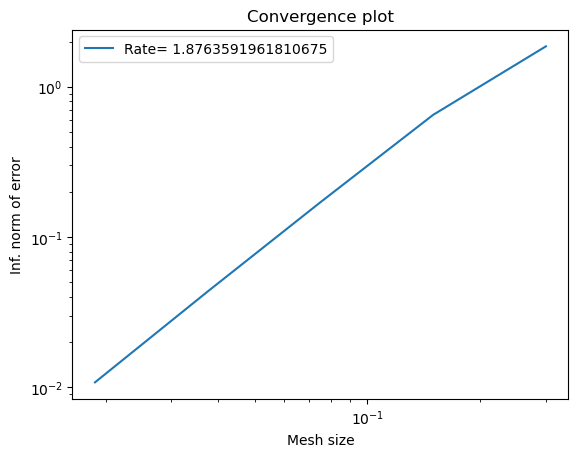

In [212]:
function test_helmconv()
    hmax = 0.3
    nrefmax = 4
    errors = helmconv(hmax, nrefmax)
    hs = [hmax / (2^i) for i=0:nrefmax]

    fit = Polynomials.fit(log.(hs), log.(errors), 1)
    order = coeffs(fit)[2]
    clf()
    fig, ax = subplots()
    ax.loglog(hs, errors, label = "Rate= $order")
    ax.set_title("Convergence plot")
    ax.set_xlabel("Mesh size")
    ax.set_ylabel("Inf. norm of error")
    ax.legend()
    display(fig)
end
test_helmconv()

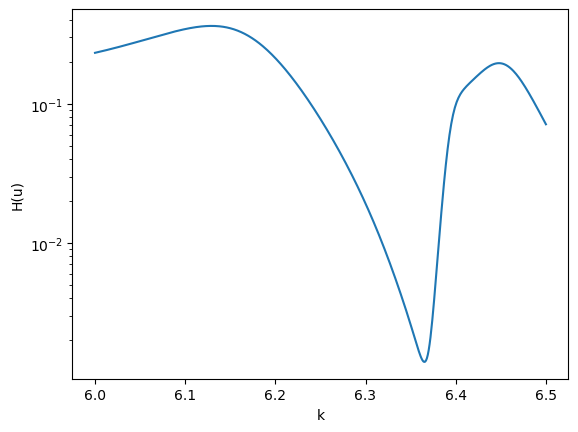

(Any[0.23261226490466147, 0.2334111987979856, 0.2342178251136645, 0.23503218561826195, 0.2358543212837531, 0.23668427222704413, 0.23752207764702032, 0.2383677757587885, 0.23922140372515863, 0.24008299758517643  …  0.09162046745377292, 0.08912658559744191, 0.08669185027547421, 0.08431625704936241, 0.08199961803050962, 0.07974158259968181, 0.07754165669739838, 0.07539922069730591, 0.07331354589185672, 0.07128380963263939], 6.0:0.001:6.5, sparse([1, 783, 784, 785, 2, 786, 787, 788, 3, 789  …  2965, 2966, 2967, 700, 752, 1823, 1824, 2965, 2966, 2967], [1, 1, 1, 1, 2, 2, 2, 2, 3, 3  …  2966, 2966, 2966, 2967, 2967, 2967, 2967, 2967, 2967, 2967], [0.8657523816575377, -0.33169235590392376, -0.33169235590392304, -0.20236766984969073, 0.882677460712364, -0.33601640656261994, -0.3812521765597061, -0.1654088775900379, 0.8771478052304604, -0.37231385023633956  …  -0.3985841683402292, 3.751754447627349, -0.3720073088195495, -0.3985841683402341, -0.3985841683402338, -0.3720073088195468, -1.105285746

In [206]:
function two_slits(display_fig = false)
    pv = [0 0; 0 1; 1.9 1; 1.9 0.2; 2.1 0.2; 2.1 1; 2.9 1; 2.9 0.2; 3.1 0.2; 3.1 1; 5 1; 5 0; 0 0]
    hmax = 0.2
    nref = 2
    p,t,e = pmesh(pv, hmax, nref)
    ein, eout, ewall = waveguide_edges(p,t)
    K, M, Bin, Bout, bin = femhelmholtz(p, t, ein, eout)
    ks = 6:0.001:6.5
    Hs = []
    for k = ks
        u = (K - k^2 * M + 1im*k*(Bin + Bout)) \ (2im  * k * bin)
        push!(Hs, real(u'*Bout*u))
    end
    if display_fig
        clf()
        fig, ax = subplots()
        ax.semilogy(ks, Hs)
        ax.set_xlabel("k")
        ax.set_ylabel("H(u)")
        display(fig)
    end
    return Hs, ks, K, M, Bin, Bout, bin, p, t
end

Hs, ks, K, M, Bin, Bout, bin, p, t = two_slits(true)

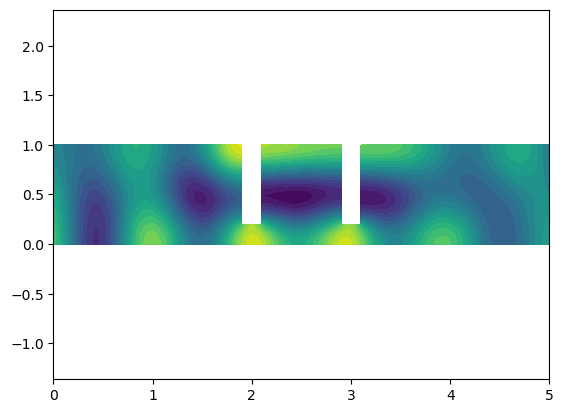

In [207]:
function twoslits_plotsolutions()
    Hs, ks, K, M, Bin, Bout, bin, p, t = two_slits()
    k_high = ks[argmax(Hs)]
    k_low = ks[argmin(Hs)]
    u_high = (K - k_high^2 * M + 1im*k_high*(Bin + Bout)) \ (2im  * k_high * bin)
    u_low = (K - k_low^2 * M + 1im*k_low*(Bin + Bout)) \ (2im  * k_low * bin)
    return p, t, u_high, u_low
end
p, t, u_high, u_low = twoslits_plotsolutions()
clf()
tplot(p, t, u_high)
gcf()

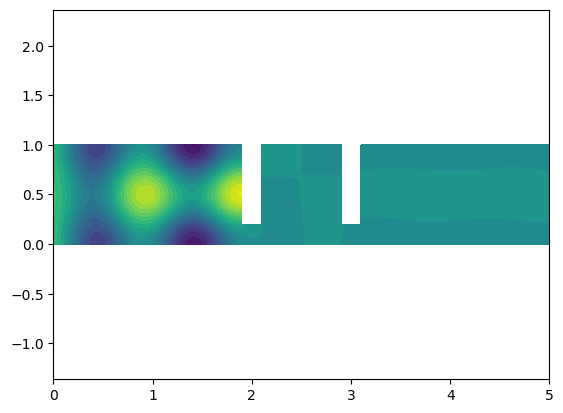

In [208]:
clf()
tplot(p, t, u_low)
gcf()

# Problem 4

In [153]:
function p2mesh(p, t)
    K = size(t, 1)
    n = size(p, 1)
    edges, bndix, emap = all_edges(t)
    e2 = unique(vcat(edges[bndix,:]...))

    visitiededges = zeros(Int64, size(edges,1))
    newt = zeros(Int64, K, 3)
    for i = 1:K 
        for j = 1:3
            edge = edges[emap[i,j],:]
            if visitiededges[emap[i,j]] == 0
                p = vcat(p, (p[edge[1],:]' + p[edge[2],:]')./2)
                newt[i,j] = size(p,1)
                visitiededges[emap[i,j]] = size(p,1)
                if emap[i,j] in bndix
                    append!(e2, size(p,1))
                end
            else
                newt[i,j] = visitiededges[emap[i,j]]
            end
        end
    end
    t2 = hcat(t, newt)
    return p, t2, e2
end

p2mesh (generic function with 1 method)

In [154]:
function fempoi2(p2, t2, e2)
    A = Tuple{Int64,Int64,Float64}[]
    K = size(t2, 1)
    n = size(p2, 1)
    b = zeros(n)

    for k = 1:K
        xloc = p2[t2[k,:],:]
        V = zeros(6,6)
        for i = 1:6
            # 1 x y xy x^2 y^2
            V[i,:] = [1 xloc[i,:]... xloc[i,1]*xloc[i,2] (xloc[i,:].^2)...]
        end
        C = inv(V)

        # Quadrature nodes
        xg = xloc[1:3,:] ./2 .+ sum([xloc[j,:]./6 for j = 1:3])'
        Ak = area(p2, t2[k,:])

        for α = 1:6
            for β = 1:6
                a1(x) = (C[2,α] + C[4,α]*x[2] + 2*C[5,α]*x[1])*(C[2,β] + C[4,β]*x[2] + 2*C[5,β]*x[1])
                a2(x) = (C[3,α] + C[4,α]*x[1] + 2*C[6,α]*x[2])*(C[3,β] + C[4,β]*x[1] + 2*C[6,β]*x[2])
                push!(A, (t2[k,α], t2[k,β], Ak/3 * sum([a1(x) + a2(x) for x = eachrow(xg)])))  
            end

            H(x) = sum([C[i,α] * [1 x... x[1]*x[2] (x.^2)...][i] for i = 1:6])

            b[t2[k,α]] += Ak/3 * sum([H(x) for x = eachrow(xg)])
        end
    end
    A = sparse((x->x[1]).(A), (x->x[2]).(A), (x->x[3]).(A), n, n)

    """
    Dirichlet conditions:
      Keep element in A if 
        i ∉ e||i==j:    row i is not a boundary node, or if it's a diagonal element 
            but don't keep it if
        j ∈ e && (i==j+1 || i==j-1):    column j is a boundary node and row i is above/below.
    """
    fkeep!(A, (i,j,x) -> (i ∉ e2||i==j) && !(j ∈ e2 && (i==j+1 || i==j-1)))
    
    for node = e2
        b[node] = 0
    end

    u = A \ b
    return u
end

function test_fempoi2()
    pv = [0 0; 1 0; 1 1; 0 1; 0 0]
    t = [1 2 4; 2 3 4]
    p, t, e = pmesh(pv, 0.3, 4)
    p2, t2, e2 = p2mesh(p, t)

    u = fempoi2(p2, t2, e2)
    tplot(p, t, u[1:size(p,1)])
    colorbar()
    gcf()
end

test_fempoi2 (generic function with 1 method)

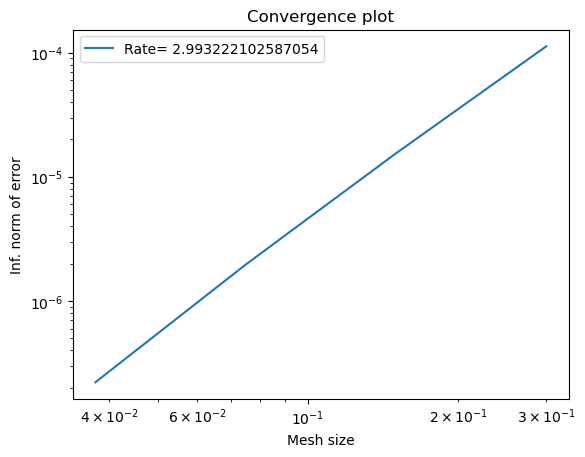

In [155]:
function fempoi2_convergence(hmax, nrefmax)
    pv = [0 0; 1 0; 1 1; 0 1; 0 0]
    p, t, e = pmesh(pv, hmax, nrefmax)
    p2, t2, e2 = p2mesh(p, t)
    u_exact = fempoi2(p2, t2, e2)

    p,t,e = pmesh(pv, hmax, 0)
    p2, t2, e2 = p2mesh(p, t)
    u = fempoi2(p2, t2, e2)
    numnodes_course = size(p,1)

    errors = [maximum(abs.(u[1:numnodes_course] - u_exact[1:numnodes_course]))]
    for nref = 1:nrefmax-1
        p,t,e = pmesh(pv, hmax, nref)
        p2, t2, e2 = p2mesh(p, t)
        u = fempoi2(p2, t2, e2)
        push!(errors, maximum(abs.(u[1:numnodes_course] - u_exact[1:numnodes_course])))
    end
    return errors
end

function test_fempoi2_convergence()
    hmax = 0.3
    nrefmax = 4
    errors = fempoi2_convergence(hmax, nrefmax)
    hs = [hmax / (2^i) for i=0:nrefmax-1]

    fit = Polynomials.fit(log.(hs), log.(errors), 1)
    order = coeffs(fit)[2]
    clf()
    fig, ax = subplots()
    ax.loglog(hs, errors, label = "Rate= $order")
    ax.set_title("Convergence plot")
    ax.set_xlabel("Mesh size")
    ax.set_ylabel("Inf. norm of error")
    ax.legend()
    display(fig)
end

test_fempoi2_convergence()